#### Configuración Inicial del Entorno

Carga las librerias necesarias para la Plataforma. *CUDA_VISIBLE_DEVICES* configura la GPU si tenemos una. En caso no tengamos una tarjeta grafica NVIDIA, debe reemplazar *gpu_num* por ""
Las librerias principales a cargar son:
- **Sionna**: Libreria NVIDIA para simulacion del sistema de comunicaciones. Incluye codigo para auto instalacion de Sionna en Google Colab
- **TensorFlow**: Backend para Sionna, permite aceleración GPU, se configura para que no anuncie warning, solo errores

En la carpeta **resources**, se incluye el archivo *yml* para duplicar el Conda environment con en el que se ejecuto este Jupyter Notebook. Se uso computador con Windows 11 + WSL2 (Ubuntu 24.04 LTS) y tarjeta NVIDIA RTX 3500 Ada generation

In [1]:
# Importa las librerias Python necesarias

# Selecciona la GPU a emplear, o CPU si no hay GPU disponible
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # cambiar a "" para usar CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Importa Sionna. En Google Colab, ejecutar toda la celda DOS veces
try:
    import sionna
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
        print("Instalando Sionna en el entorno Google Colab.")
        print("⚠️ OJO: Por favor, EJECUTA ESTA CELDA DE NUEVO.")
        os.system("pip install sionna") # instala Sionna en Google Colab
        os.kill(os.getpid(), 5)
    else:
       raise e

# Importa y configura TensorFlow
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

# Librerias generales
import numpy as np
import pandas as pd
from datetime import datetime

# Librerias para monitoreo de memoria
import psutil
import gc
import objgraph

# Mostrar graficos dentro del cuaderno
%matplotlib inline
import matplotlib.pyplot as plt

E0000 00:00:1770003692.185157   12676 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770003692.188638   12676 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770003692.198201   12676 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770003692.198224   12676 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770003692.198225   12676 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770003692.198226   12676 computation_placer.cc:177] computation placer already registered. Please check linka

#### Parámetros de Simulación

Reseumen de los parámetros más importantes:
- $N$: Longitud de código (codigo Polar restringe a potencias de 2)
- $K$: Bits de información (tambien es igual a bits sin código)
- Canales disponibles: awgn, rayleigh, rice, lognormal, suzuki (rayleigh $\times$ lognormal)
- Bloque de coherencia: Durante bloq_coher símbolos, el valor de $h$ será constante, simulando un desvanecimiento plano. $h$ es el factor aleatorio complejo que se multiplica a nuestra señal transmitida antes de la adicion de ruido
- Factor K (canal Rice): $K_{\text{dB}} = 10\log_{10}(\text{Potencia}_{\text{LOS}}/\text{Potencia}_{\text{NLOS}})$
- $\sigma_{\text{dB}}$ (canal Lognormal y Susuki): desviación estándar de la distribucion. Dado que la potencia es $E[a^2] = \exp\left(2\mu + 2\sigma^2\right)$, para lograr una potencia unitaria el valor de la media del pdf se calcula como: $- 2\sigma^2$.
- Total de muestras por bit-canal: $\text{lote\_mc} \times \text{num\_iter}$
- SNR recomendado: valores recomendados en dB para que la simulacion Monte Carlo divida los bit-canales en ruidosos (congelados) o sin ruido 

In [11]:
# Parametros generales de la Plataforma

# Parametros basicos
sionna.phy.config.seed = 0 # fija semilla aleatoria para reproducibilidad
N = 128 # longitud del código (potencia de 2 para codigo polar)
K = 64 # número de bits de información (0 < K < N, tasa R = K/N)
bitsxsimb = 1 # bits por símbolo, posibles valores: 1 (BPSK), 2 (QPSK), 4 (16-QAM), etc.
if bitsxsimb == 1:
    modulacion = "pam" # +1+0j y -1+0j para BPSK
else:
    modulacion = "qam" # para más de 1 bit por símbolo

# Parametros del canal
canal = "rice" # posibles valores: "awgn", "rayleigh", "rice", "lognormal", "suzuki"
bloq_coher = N // 16 # simbolos que mantienen el mismo h, desvanecimiento plano
k_factor_db = 6.0 # canal Rice: factor K en dB (6 a 15 dB en Sub urbano)
sigma_db = 6.0 # canal Lognormal/Suzuki: desviacion estandar (2 dB desvanecimiento leve, 6 severo)

# Parametros de la recepcion
ecualizador = "mmse" # posibles valores: "no_eq", "zf", "mmse"  
list_scl = 8 # tamaño de lista para decodificador SCL
LLR_clip = 500 # valor de recorte para LLRs, evita inestabilidades numéricas

# Parametros de simulacion. Cada bit-canal se simula lote_mc * num_iter veces
lote_mc = 2000 # numero de muestras a procesar en paralelo (emplea RAM)
num_iter = 2000 # numero de muestras a procesar en secuencia (emplea tiempo)
snr_simulacion = -0.3 # verificado: -1.2 AWGN, 1 Rayleigh, 0 Rice, 1.2 Lognormal, 2.6 Suzuki
coderate_simulacion = K / N # tasa del codigo empleada en la simulacion

# Clases Sionna comunes a todos las celdas
datos = sionna.phy.mapping.BinarySource() # generador de datos aleatorios
constelacion = sionna.phy.mapping.Constellation(modulacion, bitsxsimb) # define la constelacion (BPSK o QAM)
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion) # mapeador bits a simbolos (binario a complejo)
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion) # inverso del mapeador
interleaver = sionna.phy.fec.interleaving.RandomInterleaver(seed=0, axis=-1) # interleaver del bloque N
deinterleaver = sionna.phy.fec.interleaving.Deinterleaver(interleaver) # inverso del interleaver

# Parametros CRC (para el codigo Polar + CRC)
crc_degree = "CRC24A" # CRC de 24 bits defindo en 3GPP TS 38.212
crc_codif = sionna.phy.fec.crc.CRCEncoder(crc_degree=crc_degree)
crc_long = crc_codif.crc_length # longitud del CRC en bits (24 para CRC24A)

# Parametros de ploteo de curvas BER vs Eb/N0
EBNO_DB_MIN = 0 # Eb/N0 mínimo en dB
EBNO_DB_MAX = 20 # Eb/N0 máximo en dB
EBNO_RANGO = EBNO_DB_MAX - EBNO_DB_MIN + 1 # rango de Eb/N0
lote_berplot = 200 # tamaño de lote para ploteo de curvas

#### Modelos de Canal

Se han implementado cinco modelos de canal, relevantes para comunicaciones inalámbricas terrestres y satelitales. Todos los canales multiplican la señal por un factor de potencia unitaria. Salvo AWGN, todos los canales implementan un bloque de coherencia ($h$ constante) durante bloq_coher simbolos

##### 1. Canal AWGN
$$y = x + n, \quad n \sim \mathcal{CN}(0, N_0)$$

##### 2. Canal Rayleigh
$$y = hx + n, \quad h \sim \mathcal{CN}(0, 1)$$
- Canal multitrayecto sin LOS

##### 3. Canal Rice
$$h = \sqrt{\frac{K}{K+1}}h_{\text{LOS}} + \sqrt{\frac{1}{K+1}}h_{\text{NLOS}}$$
- Canal multitrayecto con LOS. A $K$ mas grande, mayor la influencia del componente LOS

##### 4. Canal Log-Normal
$$h = e^z, \quad z \sim \mathcal{N}(\mu, \sigma^2)$$
- Desvanecimiento profundo (shadowing)

##### 5. Canal Suzuki (Rayleigh × Log-Normal)
$$h = g \cdot a, \quad g \sim \mathcal{CN}(0,1), \quad a = e^z$$
- Combina desvanecimiento rápido (Rayleigh) y lento (Log-normal)

In [3]:
# Modelos de canal

# Canal AWGN
@tf.function(jit_compile=True)
def canalAWGN(ebno_db, bitsxsimb, coderate, x):
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    h = 1.0 + 0.0j # canal sin desvanecimiento
    y = x + awgn
    return y, h, no

# Canal Rayleigh
@tf.function(jit_compile=True)
def canalRayleigh(bloq_coher, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch de la señal
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h
    # Ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # Factor Rayleigh
    h_real = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h_imag = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h = tf.repeat(tf.complex(h_real, h_imag), repeats=bloq_coher, axis=1) # h constante durante coherencia
    h = h[:, :N] # recorta a la longitud de bloque N
    y = h * x + awgn
    return y, h, no

# Canal Rice
@tf.function(jit_compile=True)
def canalRice(bloq_coher, k_factor_db, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h
    # Ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # Valor lineal del factor K (ratio de potencias LOS/NLOS)
    k_factor_lin = tf.pow(10.0, tf.cast(k_factor_db, tf.float32) / 10.0)
    # Calculo del factor Rice
    h_nlos_real = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h_nlos_imag = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    h_nlos = tf.complex(h_nlos_real, h_nlos_imag)
    phi = sionna.phy.config.tf_rng.uniform([batch_size, repeticiones], minval=0.0, maxval=tf.constant(2.0*np.pi, tf.float32)) # fasor de LOS (amplitud constante, fase aleatoria)
    h_los = tf.complex(tf.cos(phi), tf.sin(phi))
    # Combina componentes LOS y NLOS
    a = tf.sqrt(k_factor_lin/(k_factor_lin + 1.0)) # amplitud LOS
    b = tf.sqrt(1.0/(k_factor_lin + 1.0))     # amplitud NLOS
    h_bloque = tf.cast(a, tf.complex64)*tf.cast(h_los, tf.complex64) + tf.cast(b, tf.complex64)*tf.cast(h_nlos, tf.complex64)
    h = tf.repeat(h_bloque, repeats=bloq_coher, axis=1)
    h = h[:, :N] # recorta a la longitud N
    y = h * x + awgn
    return y, h, no

# Canal Lognormal (desvanecimiento profundo)
@tf.function(jit_compile=True)
def canalLognormal(bloq_coher, sigma_db, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h
    # Ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # Calcula el valor lineal de la desviacion estandar y calcula media para potencia normalizada
    sigma_lin = tf.cast(tf.math.log(10.0) / 20.0 * sigma_db, tf.float32)
    mu_ln = -tf.square(sigma_lin) # para potencia unitaria, media = -sigma_lin^2
    # Canal Lognormal
    z = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], mean=mu_ln, stddev=sigma_lin, dtype=tf.float32)
    a = tf.exp(z) # amplitud log-normal
    a = tf.repeat(a, repeats=bloq_coher, axis=1)
    a = a[:, :N] # recorta a la longitud de bloque N
    h = tf.complex(a, tf.zeros_like(a))
    y = h * x + awgn
    return y, h, no

# Canal Suzuki (Rayleigh x Lognormal)
@tf.function(jit_compile=True)
def canalRayleighLognormal(bloq_coher, sigma_db, ebno_db, bitsxsimb, coderate, x):
    batch_size = tf.shape(x)[0] # extrae el tamaño del batch
    bloq_coher = tf.cast(bloq_coher, tf.int32) # simbolos donde h se mantiene constante
    N = tf.shape(x)[-1] # extrae la longitud de bloque N
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    repeticiones = tf.cast(tf.math.floordiv(N + bloq_coher - 1, bloq_coher), tf.int32) # repeticiones de h
    # Ruido AWGN
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0, stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag) # ruido blanco aditivo complejo
    # factor Rayleigh
    g_real = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    g_imag = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], stddev=tf.sqrt(0.5), dtype=tf.float32)
    g = tf.complex(g_real, g_imag)
    # factor Lognormal
    sigma_lin = tf.cast(tf.math.log(10.0) / 20.0 * sigma_db, tf.float32)
    mu_ln = -tf.square(sigma_lin) # para potencia unitaria, media = -sigma_lin^2
    z = sionna.phy.config.tf_rng.normal([batch_size, repeticiones], mean=mu_ln, stddev=sigma_lin, dtype=tf.float32)
    a = tf.exp(z) # amplitud Lognormal
    a_c = tf.complex(a, tf.zeros_like(a)) # canal Lognormal
    # canal compuesto Rayleigh x Lognormal
    h_comp = g * a_c
    h = tf.repeat(h_comp, repeats=bloq_coher, axis=1)
    h = h[:, :N] # recorta a la longitud de bloque N
    y = h * x + awgn
    return y, h, no

#### Ecualizadores

Estrategias de ecualización para compensar el desvanecimiento del canal:

##### 1. Sin Ecualización
$$\hat{x} = y$$

##### 2. Zero-Forcing (ZF)
$$\hat{x} = \frac{y \cdot h^*}{|h|^2}, \quad N_{0,\text{eff}} = \frac{N_0}{|h|^2}$$
- Elimina completamente la distorsión del canal
- Amplifica el ruido cuando $|h|^2 \ll 1$

##### 3. Minimum Mean Square Error (MMSE)
$$g = \frac{h^*}{|h|^2 + N_0}, \quad \hat{x} = \frac{g \cdot y}{|g \cdot h|}$$
- Potencia de ruido efectiva: $N_{0,\text{eff}} = \frac{N_0}{|h|^2}$

Todos los ecualizadores incluyen protección numérica ($\epsilon = 10^{-12}$) para evitar división por cero.

In [4]:
# Ecualizadores

# Sin ecualizador
@tf.function(jit_compile=True)
def sin_ecualizar(y, h, no):
    return y, no

# Ecualizador ZF (Zero Forcing)
@tf.function(jit_compile=True)
def zf(y, h, no, eps=1e-12):
    h2 = tf.maximum(tf.math.square(tf.abs(h)), eps)
    x_hat = y * tf.math.conj(h) / tf.cast(h2, tf.complex64)
    no_eff = no / tf.maximum(h2, eps)
    return x_hat, no_eff

# Ecualizador MMSE (Minimum Mean Square Error)
@tf.function(jit_compile=True)
def mmse(y, h, no, eps=1e-12):
    g = tf.math.conj(h) / tf.cast(tf.math.square(tf.abs(h)) + no, tf.complex64)
    d = g * h # aplica ganancia unitaria para Demapper Sionna
    d_abs = tf.maximum(tf.abs(d), eps)
    x_hat = g * y / tf.cast(d_abs, tf.complex64)
    no_eff = no / tf.maximum(tf.math.square(tf.abs(h)), eps)
    return x_hat, no_eff

#### Sistema sin Código de Canal

Implementa la cadena de comunicaciones completa **sin codificación de canal** para establecer una línea base de comparación.

**Pipeline de Transmisión-Recepción**:
$$\text{Bits} \xrightarrow{\text{Interleaver}} \text{Mapper} \xrightarrow{\text{Canal}} \text{Equalizer} \xrightarrow{\text{Demapper}} \text{Deinterleaver} \xrightarrow{} \text{LLRs}$$

- **Tasa efectiva**: $R = 1.0$ (sin redundancia)
- **Interleaver**: Aleatoriza errores en ráfaga
- **Clipping de LLRs**: $\text{LLR} \in [-500, 500]$ para estabilidad numérica

Esta clase permite evaluar el BER sin protección de código.

In [5]:
# Define el sistema de telecomunicaciones a simular, sin código de canal

class SinCodigo(sionna.phy.Block):
    def __init__(self, canal, ecualizador, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db):
        super().__init__()
        self.canal = canal
        self.ecualizador = ecualizador
        self.K = K
        self.bitsxsimb = bitsxsimb
        self.bloq_coher = bloq_coher
        self.k_factor_db = k_factor_db
        self.sigma_db = sigma_db
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = datos([batch_size, self.K])
        b_int = interleaver(b)
        x = mapeador(b_int)
        
        # Seleccion de canal
        if self.canal == "awgn":
            y, h, no = canalAWGN(ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "rayleigh":
            y, h, no = canalRayleigh(self.bloq_coher, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "rice":
            y, h, no = canalRice(self.bloq_coher, self.k_factor_db, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "lognormal":
            y, h, no = canalLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        elif self.canal == "suzuki":
            y, h, no = canalRayleighLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=1.0, x=x)
        else:
            raise Exception("⚠️ OJO: Debe seleccionar un canal valido")

        # Seleccion de ecualizador
        if self.ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif self.ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif self.ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("⚠️ OJO: Debe seleccionar un ecualizador valido")
        
        # Bloques de recepcion
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)

        return b, llr

In [6]:
# Se crea la instancia de clase sin codigo de canal

sin_codigo = SinCodigo(canal, ecualizador, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db)

I0000 00:00:1770003716.872468   12676 service.cc:152] XLA service 0x36aacbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770003716.872525   12676 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 3500 Ada Generation Laptop GPU, Compute Capability 8.9
I0000 00:00:1770003716.899418   12676 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1770003717.890651   12676 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.0883e-01 | 9.9500e-01 |        1393 |       12800 |          199 |         200 |         2.7 |reached target block errors
      1.0 | 8.3437e-02 | 9.9000e-01 |        1068 |       12800 |          198 |         200 |         0.0 |reached target block errors
      2.0 | 6.3906e-02 | 9.5500e-01 |         818 |       12800 |          191 |         200 |         0.0 |reached target block errors
      3.0 | 5.3516e-02 | 9.5000e-01 |         685 |       12800 |          190 |         200 |         0.0 |reached target block errors
      4.0 | 3.9531e-02 | 8.1500e-01 |         506 |       12800 |          163 |         200 |         0.0 |reached target block errors
      5.0 | 2.7813e-02 | 7.8500e-01 |         356 |       12800 |

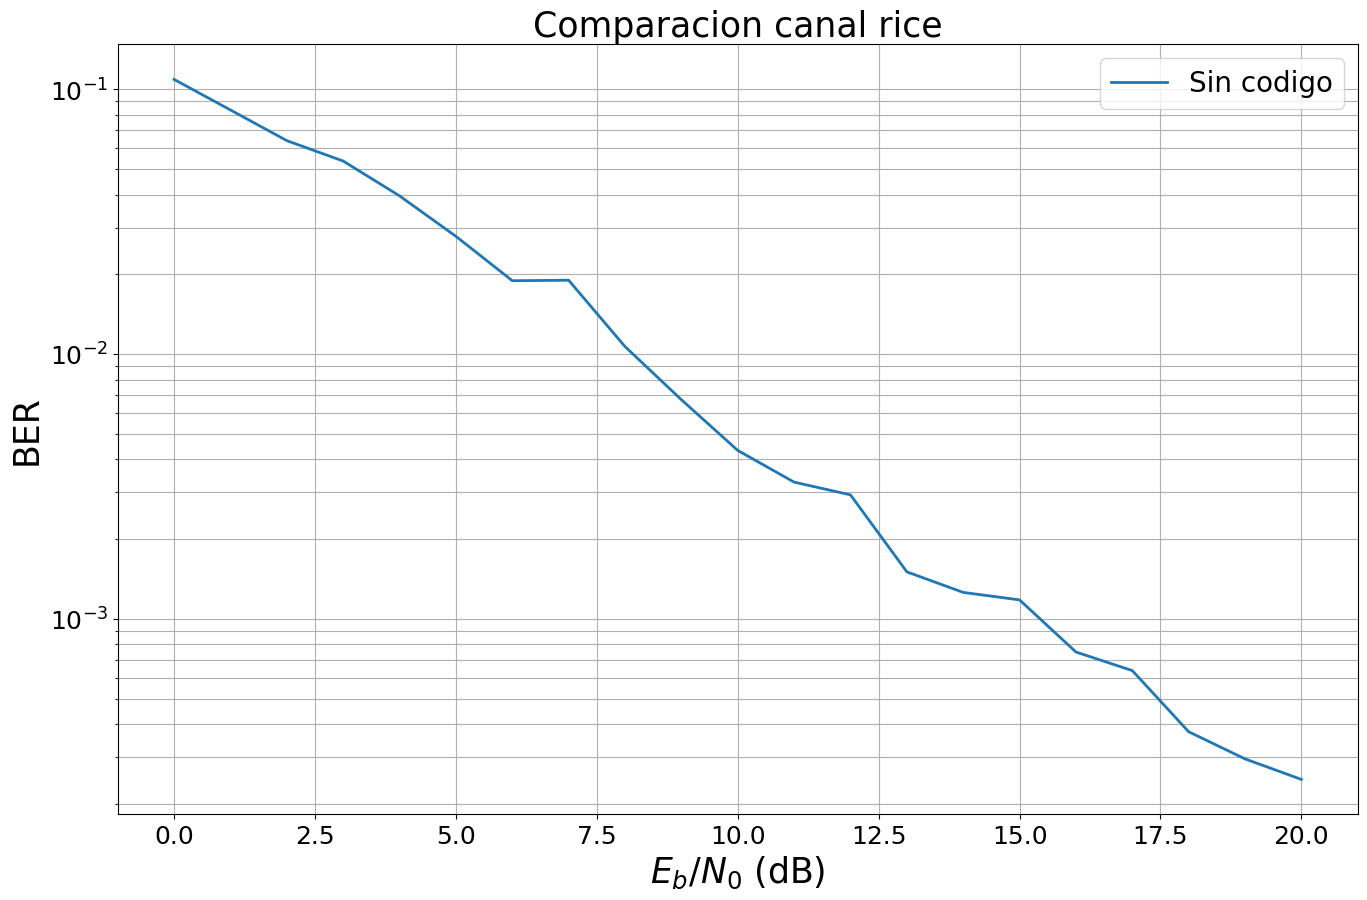

In [7]:
# Simulación y ploteo de BER sin codigo de canal

ber_plots = sionna.phy.utils.PlotBER(f"Comparacion canal {canal}")
ber_plots.simulate(sin_codigo,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_RANGO),
                   batch_size=lote_berplot,
                   num_target_block_errors=100,
                   legend="Sin codigo",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True);

#### Generación Monte Carlo de Bits Congelados

**Objetivo**: Determinar qué $N-K$ bits deben congelarse (fijarse a 0) en el codificador Polar para **maximizar el desempeño BER**.

##### Metodología
Para cada bit-canal $i \in \{0, 1, \ldots, N-1\}$:

1. **Codificacion por bit-canal**: 1 bit de información en posición $i$, resto congelado
2. **Simulación**: $\text{lote\_mc} \times \text{num\_iter}$ transmisiones independientes generan las estadísticas
3. **Métrica de BER**: $\text{BER}_i = \frac{\text{errores}_i}{\text{total\_bits}_i}$

##### Selección de Bits Congelados
$$\mathcal{F} = \{i \mid \text{BER}_i \in \text{Top}(N-K)\}$$

Los bits con **mayor BER** se congelan porque son los canales más ruidosos. Los $K$ mejores canales transportan información.

**Fundamento teórico**: El método de construcción Polar basado en Monte Carlo aproxima el proceso de polarización del canal, donde los bits de menor capacidad $I(W_i)$ se congelan.

**Aceleración**: Compilación XLA (`@tf.function(jit_compile=True)`) para ejecución eficiente en GPU.

In [12]:
# Generador Monte Carlo de bits congelados

# Estimador de BER por bit-canal usando Monte Carlo
try: # Intento de recuperar backup (si existe)
    BER_bits = np.load('BER_bits_backup.npy')
    start_index = np.count_nonzero(BER_bits) # Detecta ultimo bit-canal simulado
    print(f"Recuperado backup. Retomando desde canal {start_index}")
except:
    BER_bits = np.zeros(N)
    start_index = 0

for i in range(start_index, N):
    print(f"Procesando bit-canal {i+1}/{N}", end="", flush=True)

    # Se setean los bits congelados y genera el codificador/decodificador temporal (1 bit de informacion)
    bits_congelados = np.array([j for j in range(N) if j != i])
    codificador_temp = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
    decodificador_temp = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=1) # decodificador SC

    # Simulacion del sistema por batch_size, acelerado por GPU
    @tf.function(jit_compile=True)
    def simulacion_batch_size():
        # Bloques de transmision
        bits = datos([lote_mc, 1]) # solo 1 bit de datos por bit-canal
        bits_codif = codificador_temp(bits) # codifica a N bits
        bits_int = interleaver(bits_codif) # proteccion contra rafagas (bloq_coher > 1)
        x = mapeador(bits_int)

        # Seleccion de canal
        if canal == "awgn":
            y, h, no = canalAWGN(snr_simulacion, bitsxsimb, coderate=coderate_simulacion, x=x)
        elif canal == "rayleigh":
            y, h, no = canalRayleigh(bloq_coher, snr_simulacion, bitsxsimb, coderate=coderate_simulacion, x=x)
        elif canal == "rice":
            y, h, no = canalRice(bloq_coher, k_factor_db, snr_simulacion, bitsxsimb, coderate=coderate_simulacion, x=x)
        elif canal == "lognormal":
            y, h, no = canalLognormal(bloq_coher, sigma_db, snr_simulacion, bitsxsimb, coderate=coderate_simulacion, x=x)
        elif canal == "suzuki":
            y, h, no = canalRayleighLognormal(bloq_coher, sigma_db, snr_simulacion, bitsxsimb, coderate=coderate_simulacion, x=x)
        else:
            raise Exception("⚠️ OJO: Debe seleccionar un canal valido")

        # Seleccion de ecualizador
        if ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("⚠️ OJO: Debe seleccionar un ecualizador valido")
        
        # Bloques de recepcion
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)
        bits_decodif = decodificador_temp(llr)

        # Cálculo de errores
        err = tf.math.count_nonzero(tf.not_equal(bits, bits_decodif), dtype=tf.int32)
        
        return tf.cast(err, tf.int64), tf.constant(lote_mc, dtype=tf.int64)

    # Inicializa contadores de errores y bits
    errores_totales = 0
    bits_totales = 0

    # Se itera num_iter veces para acumular errores
    for b in range(num_iter):
        err, total = simulacion_batch_size()
        errores_totales += int(err.numpy()) # acumula errores
        bits_totales += int(total.numpy())

    BER_bits[i] = errores_totales / bits_totales # calcula BER para el bit-canal i
    print(f"| BER: {BER_bits[i]:.2e}")
    
    # Guarda backup de BER_bits cada 10 canales
    if i % 10 == 0:
        np.save('BER_bits_backup.npy', BER_bits)
        print(" [Backup guardado]") 
    
    # Libera la memoria
    del simulacion_batch_size
    del codificador_temp
    del decodificador_temp
    tf.keras.backend.clear_session()

    # Guardado de emergencia si la RAM supera el 80%
    memoria_sistema = psutil.virtual_memory()
    porcentaje_uso = memoria_sistema.percent
    if porcentaje_uso > 80.0:
        print(f"\n\n🚨 ALERTA: Memoria RAM al {porcentaje_uso}% (Umbral: 80%)")
        print("Deteniendo simulación preventivamente para evitar congelamiento")
        
        # Guardado de emergencia inmediato
        np.save('BER_bits_backup.npy', BER_bits)
        print(f"Backup de emergencia guardado en canal {i}.")        
        break # rompe el bucle
    
    # Auditoria de memoria cada 50 canales (simulacion consume mucha memoria)
    # if i % 50 == 0:
    #     print(f"\n--- Auditoría Canal {i} ---")
    #     # Muestra los 5 objetos que más han crecido en memoria
    #     objgraph.show_growth(limit=5)
        
    #     # Cuenta los tensores vivos en memoria
    #     tensor_count = 0
    #     for obj in gc.get_objects():
    #         if tf.is_tensor(obj):
    #             tensor_count += 1
    #     print(f"Tensores activos: {tensor_count}")
        
    #     # Verifica estado del backend
    #     print(f"Memoria Libre (según TF): {tf.config.experimental.get_memory_info('GPU:0') if tf.config.list_physical_devices('GPU') else 'CPU'}")

    gc.collect()

# Elimina el backup en caso haya finalizado la simulacion
if i == N - 1:
    print("✅ Simulación completada al 100%.")
    # Selecciona los bits congelados finales
    indices_ordenados = np.argsort(BER_bits)
    bits_congelados = indices_ordenados[-(N-K):]
    if os.path.exists('BER_bits_backup.npy'):
        os.remove('BER_bits_backup.npy')
        print(" [Backup eliminado]")
else:
    print(f"⚠️ La simulación se detuvo en el canal {i+1}/{N}.")
    print("Reiniciar el kernel y ejecutar nuevamente para continuar desde el último canal.")

Procesando bit-canal 1/128| BER: 5.00e-01
 [Backup guardado]
Procesando bit-canal 2/128| BER: 5.00e-01
Procesando bit-canal 3/128| BER: 5.00e-01
Procesando bit-canal 4/128| BER: 5.00e-01
Procesando bit-canal 5/128| BER: 5.00e-01
Procesando bit-canal 6/128| BER: 5.00e-01
Procesando bit-canal 7/128| BER: 5.00e-01
Procesando bit-canal 8/128| BER: 4.98e-01
Procesando bit-canal 9/128| BER: 5.00e-01
Procesando bit-canal 10/128| BER: 5.01e-01
Procesando bit-canal 11/128| BER: 5.00e-01
 [Backup guardado]
Procesando bit-canal 12/128| BER: 4.97e-01
Procesando bit-canal 13/128| BER: 5.00e-01
Procesando bit-canal 14/128| BER: 4.95e-01
Procesando bit-canal 15/128| BER: 4.93e-01
Procesando bit-canal 16/128| BER: 4.16e-01
Procesando bit-canal 17/128| BER: 5.00e-01
Procesando bit-canal 18/128| BER: 5.00e-01
Procesando bit-canal 19/128| BER: 5.00e-01
Procesando bit-canal 20/128| BER: 4.93e-01
Procesando bit-canal 21/128| BER: 5.00e-01
 [Backup guardado]
Procesando bit-canal 22/128| BER: 4.90e-01
Proces

#### Persistencia de Resultados BER

Guarda el vector BER_bits en formato CSV para análisis posterior o reutilización.

**Convención de nomenclatura**:
```
./results_N/YYMMDD_canal_ecualizador_SNR_BER_bits_N_K_numiter.csv
```

Esto evita re-ejecutar la simulación Monte Carlo si se van a usar los mismos parametros, dado que es computacionalmente costoso.

In [13]:
# Guardado variable BER_bits de la simulacion Monte Carlo

output_dir = f"results_{N}"
os.makedirs(output_dir, exist_ok=True)
fecha = datetime.now().strftime("%y%m%d")
df = pd.DataFrame({"BER bits": BER_bits})
# OJO: Modificar abajo segun nombre de archivo deseado
filename = os.path.join(output_dir,f"{fecha}_{canal}_{ecualizador}_{snr_simulacion}SNR_BER_bits_{N}_{K}_{num_iter}iter.csv")
# OJO: Modificar arriba segun nombre de archivo deseado
df.to_csv(filename, index=True)

In [ ]:
# Recupero variable BER_bits de la simulacion Monte Carlo

output_dir = "results_1024" # ejemplo
# OJO: Modificar abajo segun nombre de archivo deseado
filename = os.path.join(output_dir,f"260131_awgn_no_eq_0.0SNR_BER_bits_1024_512_2000iter.csv") # ejemplo, reusar parametros
# OJO: Modificar arriba segun nombre de archivo deseado
df = pd.read_csv(filename)
BER_bits = df["BER bits"].to_numpy()
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

#### Sistema con Código Polar

Implementa el **código Polar** utilizando los bits congelados hallados por Monte Carlo.

##### Codificación Polar
$$\mathbf{x} = \mathbf{u} \cdot G_N, \quad G_N = F^{\otimes n}, \quad F = \begin{bmatrix} 1 & 0 \\ 1 & 1 \end{bmatrix}$$

donde $\mathbf{u}$ contiene $K$ bits de información y $N-K$ bits congelados (ceros).

##### Decodificación SCL (Successive Cancellation List)
- **List size**: Mantiene $L$ hipótesis paralelas (complejidad $\mathcal{O}(LN\log N)$)
- Mejor desempeño comparado a SC

**Pipeline**:
$$\text{Bits}(K) \xrightarrow{\text{Polar}} \text{Coded}(N) \xrightarrow{\text{Interleaver}} \text{Canal} \xrightarrow{\text{Equalizer}} \text{Demapper} \xrightarrow{\text{SCL}} \hat{\text{Bits}}(K)$$

Tasa de código: $R = K/N$

In [ ]:
# Define el sistema de telecomunicaciones a simular, con código Polar

class CodigoPolar(sionna.phy.Block):
    def __init__(self, canal, ecualizador, N, K, bits_congelados, lista_SCL, bitsxsimb, bloq_coher, k_factor_db, sigma_db):
        super().__init__()
        self.canal = canal
        self.ecualizador = ecualizador
        self.N = N
        self.K = K
        self.bits_congelados = bits_congelados
        self.lista_SCL = lista_SCL
        self.bitsxsimb = bitsxsimb
        self.bloq_coher = bloq_coher
        self.k_factor_db = k_factor_db
        self.sigma_db = sigma_db
        
        # Inicializa los bloques necesarios
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(self.bits_congelados, self.N)
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(self.bits_congelados, self.N, list_size=self.lista_SCL)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = datos([batch_size, self.K])
        bits_codif = self.polar_codif(b)
        bits_int = interleaver(bits_codif)
        x = mapeador(bits_int)

        # Seleccion de canal
        if self.canal == "awgn":
            y, h, no = canalAWGN(ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rayleigh":
            y, h, no = canalRayleigh(self.bloq_coher, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rice":
            y, h, no = canalRice(self.bloq_coher, self.k_factor_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "lognormal":
            y, h, no = canalLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "suzuki":
            y, h, no = canalRayleighLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        else:
            raise Exception("⚠️ OJO: Debe seleccionar un canal valido")

        # Seleccion de ecualizador
        if self.ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif self.ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif self.ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("⚠️ OJO: Debe seleccionar un ecualizador valido")
        
        # Bloques de recepcion
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)
        b_hat = self.polar_decodif(llr)

        return b, b_hat

In [ ]:
# Se crea la instancia de clase Codigo Polar y los bits congelados obtenidos

codigo_polar = CodigoPolar(canal, ecualizador, N, K, bits_congelados, list_scl, bitsxsimb, bloq_coher, k_factor_db, sigma_db)

In [ ]:
# Simulación y ploteo de BER con codigo Polar

ber_plots.simulate(codigo_polar,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_RANGO),
                   batch_size=lote_berplot,
                   num_target_block_errors=250,
                   legend="Codigo Polar",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

#### Codigo Polar + CRC

Hace uso del codificador 3GPP CRC de Sionna para mejorar la decodificacion Polar tipo SCL. Se emplea CRC de 24 bits estandarizado en 3GPP para 5G NR.

In [ ]:
# Define el sistema de telecomunicaciones a simular, con Código Polar + CRC

class CodigoPolarCRC(sionna.phy.Block):
    def __init__(self, canal, ecualizador, N, K, crc_long, bits_congelados, lista_SCL, bitsxsimb, bloq_coher, k_factor_db, sigma_db):
        super().__init__()
        self.canal = canal
        self.ecualizador = ecualizador
        self.N = N
        self.K = K
        self.crc_long = crc_long
        self.bits_congelados = bits_congelados
        self.lista_SCL = lista_SCL
        self.bitsxsimb = bitsxsimb
        self.bloq_coher = bloq_coher
        self.k_factor_db = k_factor_db
        self.sigma_db = sigma_db
        
        # Inicializa los bloques necesarios
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(self.bits_congelados, self.N)
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(self.bits_congelados, self.N, list_size=self.lista_SCL, crc_degree=crc_degree)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        K_efec = self.K - self.crc_long
        b = datos([batch_size, K_efec])
        b_crc = crc_codif(b)
        bits_codif = self.polar_codif(b_crc)
        bits_int = interleaver(bits_codif)
        x = mapeador(bits_int)

        # Seleccion de canal
        if self.canal == "awgn":
            y, h, no = canalAWGN(ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rayleigh":
            y, h, no = canalRayleigh(self.bloq_coher, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rice":
            y, h, no = canalRice(self.bloq_coher, self.k_factor_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "lognormal":
            y, h, no = canalLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "suzuki":
            y, h, no = canalRayleighLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        else:
            raise Exception("⚠️ OJO: Debe seleccionar un canal valido")

        # Seleccion de ecualizador
        if self.ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif self.ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif self.ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("⚠️ OJO: Debe seleccionar un ecualizador valido")
        
        # Bloques de recepcion
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)
        b_crc = self.polar_decodif(llr)
        b_hat = b_crc[..., :K_efec] # elimina bits de CRC

        return b, b_hat

In [ ]:
# Se crea la instancia de clase Codigo Polar + CRC

codigo_polar_crc = CodigoPolarCRC(canal, ecualizador, N, K, crc_long, bits_congelados, list_scl, bitsxsimb, bloq_coher, k_factor_db, sigma_db)

In [ ]:
# Simulación y ploteo de BER con codigo Polar + CRC

ber_plots.simulate(codigo_polar_crc,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_RANGO),
                   batch_size=lote_berplot,
                   num_target_block_errors=250,
                   legend="Codigo Polar + CRC",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

#### Sistema con Código LDPC

Implementa la cadena completa con **código LDPC 5G NR** para comparación con Polar.

##### Código LDPC (Low-Density Parity-Check)
- **Matriz H**: Matriz de paridad dispersa ($\mathbf{H} \cdot \mathbf{c}^T = 0$)
- **Decodificación**: Algoritmo iterativo belief propagation (BP)
- **Estándar**: 3GPP 5G NR (38.212)

**Pipeline**:
$$\text{Bits}(K) \xrightarrow{\text{LDPC}} \text{Coded}(N) \xrightarrow{\text{Interleaver}} \text{Canal} \xrightarrow{\text{Equalizer}} \text{Demapper} \xrightarrow{\text{BP}} \hat{\text{Bits}}(K)$$

In [ ]:
# Define el sistema de telecomunicaciones a simular, con código LDPC

class CodigoLDPC(sionna.phy.Block):
    def __init__(self, canal, ecualizador, N, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db):
        super().__init__()
        self.canal = canal
        self.ecualizador = ecualizador
        self.N = N
        self.K = K
        self.bitsxsimb = bitsxsimb
        self.bloq_coher = bloq_coher
        self.k_factor_db = k_factor_db
        self.sigma_db = sigma_db
        
        # Inicializa los bloques necesarios
        self.ldpc_codif = sionna.phy.fec.ldpc.encoding.LDPC5GEncoder(self.K, self.N, self.bitsxsimb)
        self.ldpc_decodif = sionna.phy.fec.ldpc.decoding.LDPC5GDecoder(self.ldpc_codif)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = datos([batch_size, self.K])
        bits_codif = self.ldpc_codif(b)
        bits_int = interleaver(bits_codif)
        x = mapeador(bits_int)

        # Seleccion de canal
        if self.canal == "awgn":
            y, h, no = canalAWGN(ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rayleigh":
            y, h, no = canalRayleigh(self.bloq_coher, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "rice":
            y, h, no = canalRice(self.bloq_coher, self.k_factor_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "lognormal":
            y, h, no = canalLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        elif self.canal == "suzuki":
            y, h, no = canalRayleighLognormal(self.bloq_coher, self.sigma_db, ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)
        else:
            raise Exception("⚠️ OJO: Debe seleccionar un canal valido")

        # Bloques de recepcion
        if self.ecualizador == "no_eq":
            x_hat, no_eff = sin_ecualizar(y, h, no)
        elif self.ecualizador == "zf":
            x_hat, no_eff = zf(y, h, no)
        elif self.ecualizador == "mmse":
            x_hat, no_eff = mmse(y, h, no)
        else:
            raise Exception("⚠️ OJO: Debe seleccionar un ecualizador valido")
        
        llr_prev = tf.clip_by_value(demapeador(x_hat, no_eff), -LLR_clip, LLR_clip)
        llr = deinterleaver(llr_prev)
        b_hat = self.ldpc_decodif(llr)

        return b, b_hat

In [ ]:
# Se crea la instancia de clase Codigo LDPC

codigo_ldpc = CodigoLDPC(canal, ecualizador, N, K, bitsxsimb, bloq_coher, k_factor_db, sigma_db)

In [ ]:
# Simulación y ploteo de BER con codigo LDPC

ber_plots.simulate(codigo_ldpc,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_RANGO),
                   batch_size=lote_berplot,
                   num_target_block_errors=250,
                   legend="Codigo LDPC",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);